# Training the Final RFC Model

In [1]:
import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
import pickle
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from fastai.metrics import accuracy_thresh
from fastai.metrics import fbeta
from fastai.torch_core import np2model_tensor
from sklearn.metrics import accuracy_score

In [2]:
#Functions for adding features including pI and one-hot encoding

from pyteomics import mass
from pyteomics import parser
from pyteomics import electrochem
import numpy as np
from numpy import array
from numpy import argmax         
from keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences

def addfeatures(featurestable, seqlabel = 'Sequence'):
    Mass = list()
    pI = list()
    Charge = list()
    
    for i in range(0, featurestable.shape[0]):
        ps = parser.parse(featurestable[seqlabel][i], show_unmodified_termini=True)
        
        Mass.append(mass.calculate_mass(parsed_sequence=ps))
        Charge.append(electrochem.charge(ps, 2.5))
        pI.append(electrochem.pI(featurestable[seqlabel][i]))
        
    
    featurestable['pyMass'] = Mass
    featurestable['pI'] = pI
    featurestable['pyCharge'] = Charge
    
    return(featurestable)


def simpleOneHot(data_frame, sequenceTag = 'ModSequence', alphabet = 'ACDEFGHIKLMNPQRSTVWY'):
    #Start by finding the max and calculating needed vector length
    VEC_LENGTH = max(data_frame['Length']) * len(alphabet)
    
    #Define what residues are possible
    AMINO_ACIDS = alphabet 
    
    #TURNING CHARACTERS INTO INTEGERS
    # Map character keys to integer values in a dictionary, then map integer keys to character values to revers transform
    char_to_int = dict((c, i) for i, c in enumerate(AMINO_ACIDS))   #character keys to integer values
    int_to_char = dict((i, c) for i, c in enumerate(AMINO_ACIDS))   #integer keys to character values
    
    
    hotlist = list()
    #Build out the rest of the sequences' one-hot arrays
    
    for i in range(0, data_frame.shape[0]):
        
        pep = data_frame[sequenceTag][i]
        #print(pep)
        integer_encode = [char_to_int[char] for char in pep]
        encoded = to_categorical(integer_encode, num_classes=22)
        flatencode = encoded.flatten()
        
        #numzeros = VEC_LENGTH - len(flatencode)
        #flatencode = np.append(flatencode, [[0] * numzeros])
        
        hotlist.append(flatencode)
    
    padded = pad_sequences(hotlist, padding= 'post', maxlen=VEC_LENGTH)
    
    hotarray = np.array(padded)
    
    hotarray.shape
    return(hotarray)

Using TensorFlow backend.
C:\Users\jmcketney.AD\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\jmcketney.AD\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\jmcketney.AD\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np

In [3]:
data_df = pd.read_csv("C:Users/jmcketney.AD/Desktop/FAIMS_MachineLearning/Data/human/Full_HumanData_PermissiveLabels.csv", low_memory=False) #read in data for target prediction
#Add pyteomics features
data_df = addfeatures(data_df)
#Make one hot array
data_hotarray = simpleOneHot(data_frame=data_df, alphabet='ACDEFGHIKLMNPQRSTVWYam')

In [27]:
data_df.shape

(122847, 26)

In [4]:
feature_subset = ['Charge', 'Length', 'pyMass', 'pI']
X = np.concatenate((data_df[feature_subset], data_hotarray), axis = 1)
y = data_df.loc[ : ,  'X20':'X95'].values

In [ ]:
multiforest = OneVsRestClassifier(RandomForestClassifier(n_estimators = 450, min_samples_split=9, max_depth=30, max_features=0.3807, 
                                     random_state=23, min_samples_leaf = 6, class_weight = 'balanced_subsample'))
multiforest.fit(X, y)


In [38]:
#Saving the model
import pickle
#filename = 'RFC_TrainedOnFullHuman.sav'
#pickle.dump(multiforest, open('C:Users/jmcketney.AD/Desktop/FAIMS_MachineLearning/standard_models/RFC_TrainedOnFullHuman.sav', 'wb'))

In [43]:
ecoli_y.shape

(40967, 16)

## Testing the Model

In [7]:
#Loading the model
loaded_multiforest = pickle.load(open('C:Users/jmcketney.AD/Desktop/FAIMS_MachineLearning/standard_models/RFC_TrainedOnFullHuman.sav', 'rb'))

In [6]:
#Testing the model
ecoli_df = pd.read_csv('C:Users/jmcketney.AD/Desktop/FAIMS_MachineLearning/Data/ecoli/ProcessedLabelled_Ecoli.csv', low_memory=False)

In [7]:
ecoli_df = addfeatures(ecoli_df)
ecoli_hotarray = simpleOneHot(data_frame=ecoli_df, alphabet='ACDEFGHIKLMNPQRSTVWYam')

In [8]:
feature_subset = ['Charge', 'Length', 'pyMass', 'pI']
ecoli_X = np.concatenate((ecoli_df[feature_subset], ecoli_hotarray), axis = 1)
ecoli_y = ecoli_df.loc[ : ,  'X20':'X95'].values

In [8]:
predict_ecoli = loaded_multiforest.predict(ecoli_X)
predprob_ecoli = loaded_multiforest.predict_proba(ecoli_X)


In [9]:
Recall = recall_score(ecoli_y, predict_ecoli, average = 'weighted')
Precision = precision_score(ecoli_y, predict_ecoli, average = 'weighted')
RocAuc = roc_auc_score(ecoli_y, predprob_ecoli, average  = 'weighted')
F2 = 5 * (Precision * Recall) / ((4 * Precision) + Recall)
Accuracy = accuracy_score(ecoli_y.flatten(), predict_ecoli.flatten())
match_sum = np.sum((ecoli_y * predict_ecoli), axis = 1)
prop_match = (match_sum > 0).sum()/match_sum.shape[0]

print('Recall: ', Recall)
print('Precision: ', Precision)
print('ROCAUC: ', RocAuc)
print('F2: ', F2)
print('Accuracy: ', Accuracy)
print('Any Match: ', prop_match)

Recall:  0.8084055834415622
Precision:  0.4347121149024127
ROCAUC:  0.8347249262102157
F2:  0.6898088980081657
Accuracy:  0.8022478458271292
Any Match:  0.8850782337002954


In [41]:
Ecoli_true_prob_predict = pd.concat([ecoli_df['SeqCharge'], pd.DataFrame(np.concatenate([ecoli_y, predprob_ecoli, predict_ecoli], axis=1))], axis=1)
#Ecoli_c_true_prob_predict = pd.DataFrame(np.concatenate([ecoli_y, predprob_ecoli2, predict_ecoli2], axis=1))                             

In [42]:
Ecoli_true_prob_predict.to_csv('D:/Projects/FAIMS_MachineLearning/2020/July/Ecoli_true_prob_predict.csv')
#Ecoli_c_true_prob_predict.to_csv('D:/Projects/FAIMS_MachineLearning/2020/July/ConservativeTrained_Ecoli_true_prob_predict.csv')


Bringing the predictions, trues and probs down separately

In [44]:
RFC_predicts = pd.concat([ecoli_df['SeqCharge'], pd.DataFrame(predict_ecoli)], axis=1) 
RFC_probs = pd.concat([ecoli_df['SeqCharge'], pd.DataFrame(predprob_ecoli)], axis=1)
RFC_true = pd.concat([ecoli_df['SeqCharge'], pd.DataFrame(ecoli_y)], axis=1)

In [46]:
RFC_predicts.to_csv('C:/Users/jmcketney.AD/Desktop/FAIMS_MachineLearning/standard_models/ecoli_predictions/RFC_ecoli_binary_predictions.csv')
RFC_probs.to_csv('C:/Users/jmcketney.AD/Desktop/FAIMS_MachineLearning/standard_models/ecoli_predictions/RFC_ecoli_prob_predictions.csv')
RFC_true.to_csv('C:/Users/jmcketney.AD/Desktop/FAIMS_MachineLearning/standard_models/ecoli_predictions/RFC_ecoli_true.csv')


## Pulling in Predictions from Neural Net

In [37]:
nn_ecoli_y_df = pd.read_csv('C:/Users/jmcketney.AD/Desktop/FAIMS_MachineLearning/neural_net/Ecoli_predictions/LSTM_ecoli_true.csv')
nn_predict_ecoli = pd.read_csv(
    'C:/Users/jmcketney.AD/Desktop/FAIMS_MachineLearning/neural_net/Ecoli_predictions/LSTM_ecoli_binary.csv')
nn_predprob_ecoli = pd.read_csv('C:/Users/jmcketney.AD/Desktop/FAIMS_MachineLearning/neural_net/Ecoli_predictions/LSTM_ecoli_probs.csv')


In [38]:
nn_ecoli_y = nn_ecoli_y_df.loc[:, 'X20':'X95'].values
nn_predict_ecoli = nn_predict_ecoli.loc[:, 'X20':'X95'].values
nn_predprob_ecoli = nn_predprob_ecoli.loc[:, 'X20':'X95'].values

In [28]:
ecoli_df['SeqCharge'].equals(nn_ecoli_y_df['SeqCharge'])

True

## Plotting Performance

### Random Forest Classifier

In [41]:
ecoli_data = pd.read_csv('D:/Projects/FAIMS_MachineLearning/2020/July/Ecoli_true_prob_predict.csv', low_memory=False)

In [42]:
ecoli_data.shape

(40974, 50)

In [8]:
ecoli_y = ecoli_data.iloc[:, 1:17].values
predprob_ecoli = ecoli_data.iloc[:, 17:33].values
predict_ecoli = ecoli_data.iloc[:, 33:49].values

In [23]:
#ROC AUC Curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr = dict()
tpr = dict()
roc_auc = dict()
Full_rocauc = roc_auc_score(ecoli_y, predprob_ecoli, average=None)
for i in range(16):
    fpr[i], tpr[i], _ = roc_curve(ecoli_y[:, i], predprob_ecoli[:, i])
    roc_auc[i] = Full_rocauc[i]

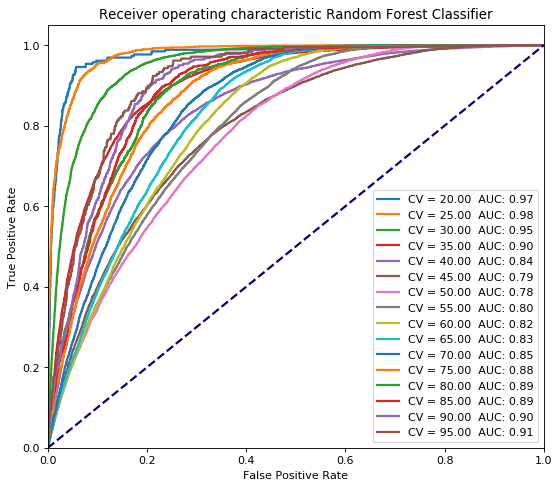

In [48]:
#Could make a dictionary to control color 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
#fig=
plt.figure(figsize=(8, 7), dpi= 80, facecolor='w', edgecolor='k')
#plt.figure()
lw = 2
for i in range(16):
    plt.plot(fpr[i], tpr[i], #color='darkorange',
             lw=lw, label='CV = %0.2f  AUC: %0.2f' % ((float(i) *5.0 + 20), Full_rocauc[i])) #, Full_rocauc[i] )
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', )
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Random Forest Classifier')
plt.legend(loc="lower right")
plt.savefig('D:/Projects/FAIMS_MachineLearning/2020/Figure_Development/ROC_Curve_EcoliTest.svg')
plt.show()

### Neural Net

In [15]:
type(nn_ecoli_y)

pandas.core.frame.DataFrame

In [25]:
nn_ecoli_y[1,:]

array([3.243807e-05, 8.596498e-04, 2.106979e-02, 2.221842e-01, 7.028090e-01, 7.722290e-01, 4.163983e-01, 7.527453e-02,
       7.160727e-03, 3.431014e-03, 1.030741e-03, 4.659509e-04, 2.077454e-04, 1.023488e-04, 7.218038e-05])

In [31]:
nn_predprob_ecoli.shape

(40967, 15)

In [39]:
#ROC AUC Curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

nn_fpr = dict()
nn_tpr = dict()
nn_roc_auc = dict()
nn_Full_rocauc = roc_auc_score(ecoli_y, nn_predprob_ecoli, average=None)
for i in range(16):
    nn_fpr[i], nn_tpr[i], _ = roc_curve(ecoli_y[:,i], nn_predprob_ecoli[:, i])
    nn_roc_auc[i] = nn_Full_rocauc[i]

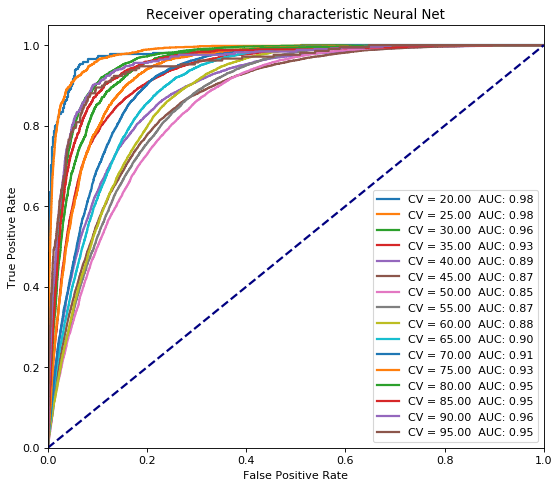

In [49]:
#Could make a dictionary to control color 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
#fig=
plt.figure(figsize=(8, 7), dpi= 80, facecolor='w', edgecolor='k')
#plt.figure()
lw = 2
for i in range(16):
    plt.plot(nn_fpr[i], nn_tpr[i], #color='darkorange',
             lw=lw, label='CV = %0.2f  AUC: %0.2f' % ((float(i) *5.0 + 20), nn_Full_rocauc[i])) #, Full_rocauc[i] )
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', )
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Neural Net')
plt.legend(loc="lower right")
plt.savefig('D:/Projects/FAIMS_MachineLearning/2020/Figure_Development/NN_ROC_Curve_EcoliTest.svg')
plt.show()

## Dummy Classifier for Ecoli Data

In [9]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy = 'uniform', random_state=23)
dummy_clf.fit(X, y)

DummyClassifier(constant=None, random_state=23, strategy='uniform')

In [10]:
dummy_pred = dummy_clf.predict(ecoli_X)
#dummy_prob = dummy_clf.predict_proba(test_X)
dummy_prob = np.array([[0.5]*dummy_pred.shape[1]] * dummy_pred.shape[0])

In [11]:
Recall = recall_score(ecoli_y, dummy_pred, average = 'weighted')
Precision = precision_score(ecoli_y, dummy_pred, average = 'weighted')
RocAuc = roc_auc_score(ecoli_y, dummy_prob, average  = 'weighted')
F2 = 5 * (Precision * Recall) / ((4 * Precision) + Recall)
Accuracy = accuracy_score(ecoli_y.flatten(), dummy_pred.flatten())
match_sum = np.sum((ecoli_y * dummy_pred), axis = 1)
prop_match = (match_sum > 0).sum()/match_sum.shape[0]

print('Recall: ', Recall)
print('Precision: ', Precision)
print('ROCAUC: ', RocAuc)
print('F2: ', F2)
print('Accuracy: ', Accuracy)
print('Any Match: ', prop_match)

Recall:  0.501058888225865
Precision:  0.2166049281725097
ROCAUC:  0.5
F2:  0.3968318934631557
Accuracy:  0.5003310591451656
Any Match:  0.7253643176215002


In [13]:
Ecoli_dummies = pd.concat((ecoli_df['SeqCharge'], pd.DataFrame(dummy_pred)), axis = 1)

In [14]:
Ecoli_dummies.to_csv('C:/Users/jmcketney.AD/Desktop/FAIMS_MachineLearning/standard_models/dummy_predictions/ecoli_dummypredictions.csv')

## Performance metrics of individual CVs

In [44]:
ecoli_df = pd.read_csv('C:/Users/jmcketney.AD/Desktop/FAIMS_MachineLearning/standard_models/ecoli_predictions/RFC_ecoli_true.csv')
nn_predict_ecoli = pd.read_csv(
    'C:/Users/jmcketney.AD/Desktop/FAIMS_MachineLearning/neural_net/Ecoli_predictions/LSTM_ecoli_binary.csv')
nn_predprob_ecoli = pd.read_csv('C:/Users/jmcketney.AD/Desktop/FAIMS_MachineLearning/neural_net/Ecoli_predictions/LSTM_ecoli_probs.csv')


rfc_predict_ecoli = pd.read_csv('C:/Users/jmcketney.AD/Desktop/FAIMS_MachineLearning/standard_models/ecoli_predictions/RFC_ecoli_binary_predictions.csv')
rfc_predprob_ecoli = pd.read_csv('C:/Users/jmcketney.AD/Desktop/FAIMS_MachineLearning/standard_models/ecoli_predictions/RFC_ecoli_prob_predictions.csv')

In [45]:
#All rows in the same order so aligned 
ecoli_y = ecoli_df.loc[:, '0':'15'].values

rfc_predict_ecoli = rfc_predict_ecoli.loc[:, '0':'15'].values
rfc_predprob_ecoli = rfc_predprob_ecoli.loc[:, '0':'15'].values

nn_predict_ecoli = nn_predict_ecoli.loc[:, 'X20':'X95'].values
nn_predprob_ecoli = nn_predprob_ecoli.loc[:, 'X20':'X95'].values

In [46]:
rfc_predict_ecoli[0:2, :]

array([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]], dtype=int64)

In [50]:
#Recall
nn_recall = recall_score(ecoli_y, nn_predict_ecoli, average = None)
rfc_recall = recall_score(ecoli_y, rfc_predict_ecoli, average = None)
print("Neural Net: ", nn_recall)
print("Random Forest: ", rfc_recall)


Neural Net:  [0.352713 0.752109 0.77162  0.694818 0.691925 0.634549 0.570344 0.549417 0.487603 0.198219 0.43559  0.391588 0.224576
 0.073386 0.044088 0.004785]
Random Forest:  [0.693798 0.849448 0.864811 0.844171 0.750922 0.740401 0.774898 0.842557 0.874197 0.855072 0.837336 0.840827 0.822034
 0.753425 0.669339 0.578947]


In [51]:
#Precision
nn_precision = precision_score(ecoli_y, nn_predict_ecoli, average = None)
rfc_precision = precision_score(ecoli_y, rfc_predict_ecoli, average = None)
print("Neural Net: ", nn_precision)
print("Random Forest: ", rfc_precision)


Neural Net:  [0.56875  0.675015 0.636662 0.710058 0.673425 0.686314 0.647908 0.643388 0.613341 0.682787 0.536579 0.518483 0.550445
 0.465839 0.431373 0.166667]
Random Forest:  [0.197572 0.423625 0.468245 0.514514 0.556459 0.519749 0.464693 0.437403 0.389844 0.337726 0.279275 0.206298 0.150872
 0.109749 0.066974 0.038122]


In [52]:
#F2
nn_F2 = 5 * (nn_precision * nn_recall) / ((4 * nn_precision) + nn_recall)
rfc_F2 = 5 * (rfc_precision * rfc_recall) / ((4 * rfc_precision) + rfc_recall)
print("Neural Net: ", nn_F2)
print("Random Forest: ", rfc_F2)

Neural Net:  [0.381711 0.735313 0.740237 0.697814 0.688144 0.644268 0.584335 0.565949 0.50845  0.231007 0.452627 0.411742 0.254738
 0.088256 0.053737 0.005938]
Random Forest:  [0.461816 0.707262 0.739544 0.748283 0.701866 0.682456 0.683627 0.710866 0.700206 0.65454  0.598247 0.520585 0.435005
 0.346722 0.239152 0.150873]
